<a href="https://colab.research.google.com/github/DM-ILLER/German-Credit-Risk/blob/main/credit_risk_estimation_oreilly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Analysis Problem Statement

## Introduction

Risk Bucketing - grouping borrowers with similar creditworthiness. Treating borrowerws wtih different risk levels equally may result in poor predictions because the model cannot capture entirely different characterisitcs of the data at once. Therefore, dividing the borrowers into different groups based on riskiness enables us to make more accurate predictions. 

## Loading the data

In [ ]:
from google.colab import files
files.upload()

Saving german_credit_data.csv to german_credit_data.csv


{'german_credit_data.csv': b',Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk\n0,67,male,2,own,NA,little,1169,6,radio/TV,good\n1,22,female,2,own,little,moderate,5951,48,radio/TV,bad\n2,49,male,1,own,little,NA,2096,12,education,good\n3,45,male,2,free,little,little,7882,42,furniture/equipment,good\n4,53,male,2,free,little,little,4870,24,car,bad\n5,35,male,1,free,NA,NA,9055,36,education,good\n6,53,male,2,own,quite rich,NA,2835,24,furniture/equipment,good\n7,35,male,3,rent,little,moderate,6948,36,car,good\n8,61,male,1,own,rich,NA,3059,12,radio/TV,good\n9,28,male,3,own,little,moderate,5234,30,car,bad\n10,25,female,2,rent,little,moderate,1295,12,car,bad\n11,24,female,2,rent,little,little,4308,48,business,bad\n12,22,female,2,own,little,moderate,1567,12,radio/TV,good\n13,60,male,1,own,little,little,1199,24,car,bad\n14,28,female,2,rent,little,little,1403,15,car,good\n15,32,female,1,own,moderate,little,1282,24,radio/TV,bad\n16,53,male,2,own,NA,NA,2424,24,

In [ ]:
# Import the German credit dataset and drop the unecessary column
import pandas as pd

credit = pd.read_csv("german_credit_data.csv").drop(["Unnamed: 0"], axis=1)
credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [ ]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


# Early Data Analysis

In [ ]:
# View summary statistics
credit.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


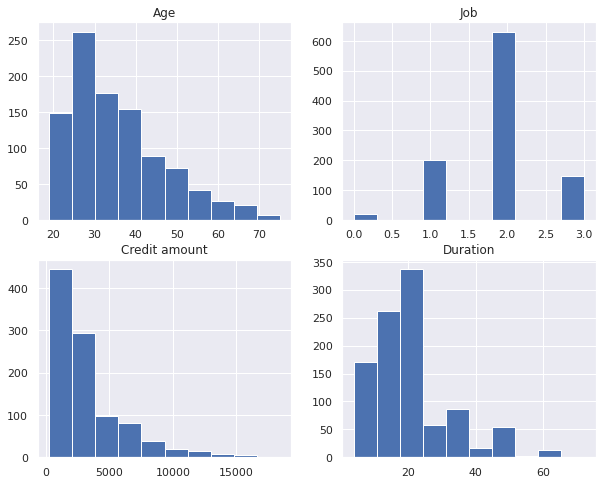

In [ ]:
# Distributions of the numerical variables
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)

numerical_credit = credit.select_dtypes(exclude='O')

plt.figure(figsize=(10, 8))
k = 0
cols = numerical_credit.columns
for i, j in enumerate(cols):
  k += 1
  plt.subplot(2, 2, k)
  plt.hist(numerical_credit.iloc[:, i])
  plt.title(j)

None of the numeric variables in the dataset follow a normal distribution. The age, credit amount, and duration variables are all skewed right.

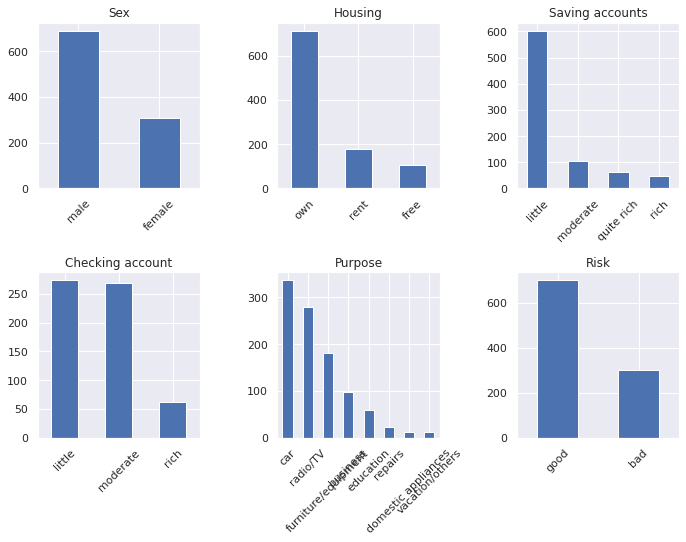

In [ ]:
# Value counts of the categorical variables
categorical_credit = credit.select_dtypes(include="O")

cols = categorical_credit.columns
plt.figure(figsize=(10, 8))
k = 0

for i, j in enumerate(cols):
  k += 1
  plt.subplot(2, 3, k)
  categorical_credit[j].value_counts().plot(kind='bar')
  plt.xticks(rotation=45)
  plt.tight_layout(pad=2.0)
  plt.title(j)

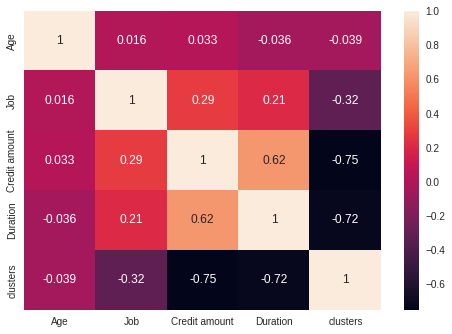

In [ ]:
import seaborn as sns
sns.heatmap(credit.corr(), annot=True);

We notice the credit amount and duration to be the only two variables with a strong correlation.

In [ ]:
for col in credit.columns:
  if credit[col].isnull().any():
    print(f"{col}: {credit[col].isnull().sum()}")

Saving accounts: 183
Checking account: 394


## Deciding the Optimal Number of Clusters

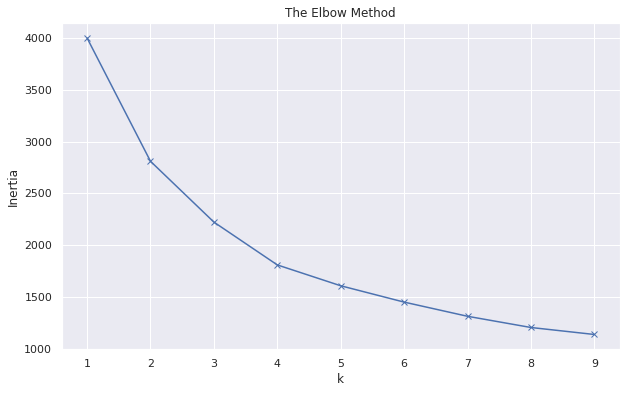

In [ ]:
# The elbow method
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

scaler = StandardScaler()
scaled_credit = scaler.fit_transform(numerical_credit)

distance = []
for k in range(1, 10):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(scaled_credit)
  distance.append(kmeans.inertia_)

plt.plot(range(1, 10), distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

The elbow method suggest that we use four clusters for risk bucketing.

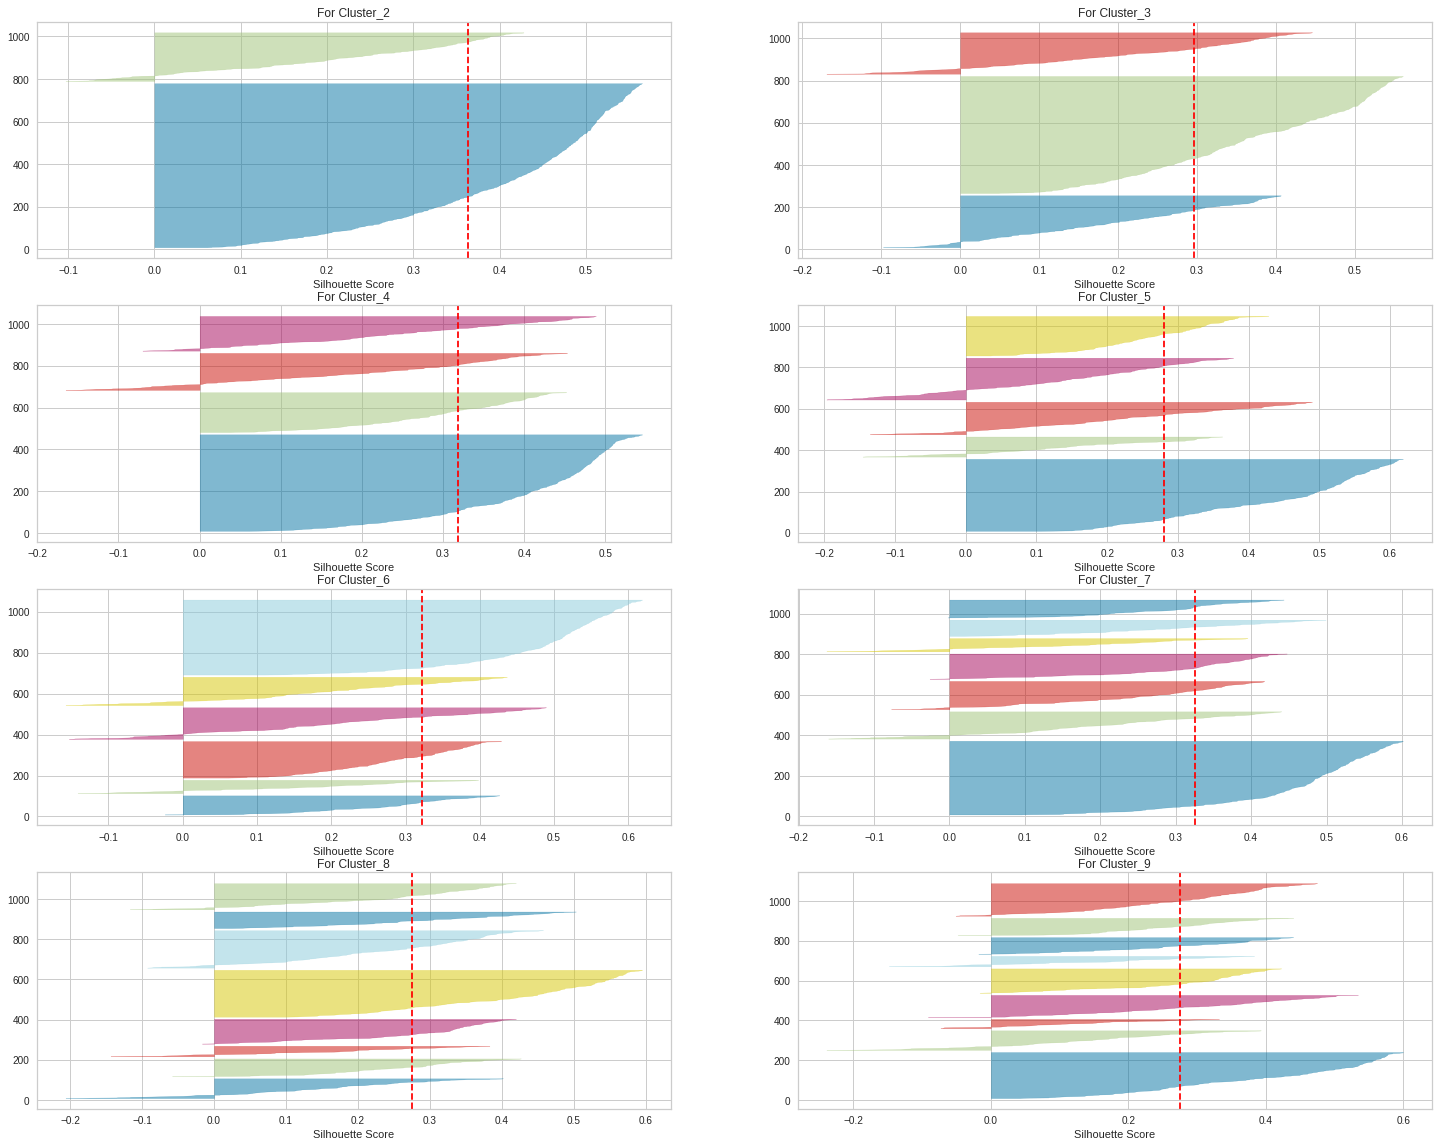

In [ ]:
# Silhouette scores technique
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(25, 20))
for i in range(2, 10):
  km = KMeans(n_clusters=i)
  q, r = divmod(i, 2)
  visualizer = SilhouetteVisualizer(km, colors='yellowbrick',
                                    ax=ax[q-1][r])
  visualizer.fit(scaled_credit)
  ax[q-1][r].set_title(f"For Cluster_{i}")
  ax[q-1][r].set_xlabel("Silhouette Score")

Given the average Silhouette score represented by the dashed line, the optimal number of clusters is two since has the score closest to 1.0.

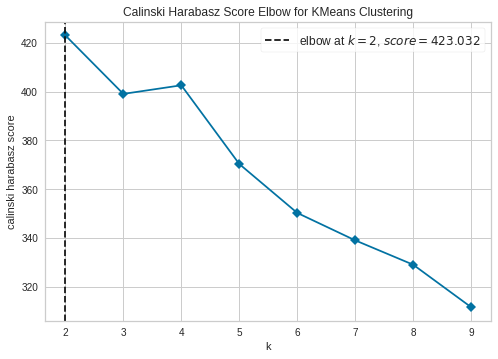

In [ ]:
# Calinski Harabasz technique
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10),
                              metric='calinski_harabasz',
                              timings=False)
visualizer.fit(scaled_credit)
visualizer.show();

The visualization of the Calinski Harabasz technique illustrates that the elbow occurs at the seconds cluster, indicating that stopping at two clusters is the optimum decision.

In [ ]:
!pip install gap-stat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Gap analysis technique
from gap_statistic import OptimalK

optimalK = OptimalK(n_jobs=8, parallel_backend='joblib')
n_clusters = optimalK(scaled_credit, cluster_array=np.arange(1, 10))

gap_result = optimalK.gap_df
gap_result.head()

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,1.0,0.902800,101.566249,0.011868,5866.520646,6775.089686,-0.007647,6580.478814
1,2.0,0.959542,313.636520,0.049095,4534.229769,5248.187937,-0.037267,5160.685927
2,3.0,1.031800,190.914535,0.034991,4015.620888,4642.077046,-0.057898,4611.904059
3,4.0,1.133321,210.151482,0.043623,3811.221599,4407.504769,0.085074,4296.706557
4,5.0,1.060065,49.217433,0.011818,3135.340910,3620.825868,0.033661,3572.654883


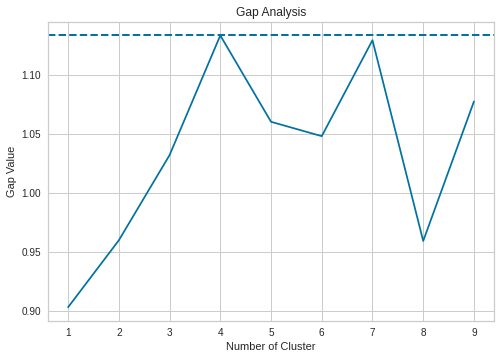

In [ ]:
# Visualizing the gap analyis
plt.plot(gap_result.n_clusters, gap_result.gap_value)
min_ylim, max_ylim = plt.ylim()
plt.axhline(np.max(gap_result.gap_value),
            linestyle='dashed', linewidth=2)
plt.title('Gap Analysis')
plt.xlabel('Number of Cluster')
plt.ylabel('Gap Value')
plt.show()

We observe a sharp increase to the point at which the gap value reaches its peak, and the analysis suggests stopping at the maximum value. In this case, we find the value at cluster 5, so this is the cut-off point.

After running four different cluster optimization algorithms, two clusters are chosen to be the optimal number of clusters

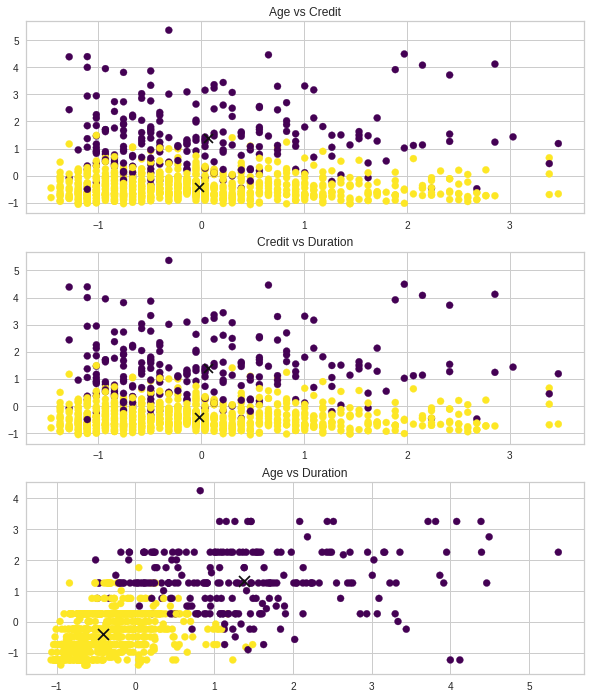

In [ ]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(scaled_credit)

plt.figure(figsize=(10, 12))
plt.subplot(311)
plt.scatter(scaled_credit[:, 0], scaled_credit[:, 2],
            c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 2], s=80,
            marker='x', color='k')
plt.title('Age vs Credit')
plt.subplot(312)
plt.scatter(scaled_credit[:, 0], scaled_credit[:, 2],
            c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 2], s=80,
            marker='x', color='k')
plt.title('Credit vs Duration')
plt.subplot(313)
plt.scatter(scaled_credit[:, 2], scaled_credit[:, 3],
            c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 2],
            kmeans.cluster_centers_[:, 3], s=120,
            marker='x', color='k')
plt.title('Age vs Duration')
plt.show()

The plots above illustrate the behavior of the observations and cross sign `x` indicates the cluster center. Age represents the more dispersed data, and the centroid of the age variable is located above the credit variable. The credit and duration plot suggests thtat the duration variable is more volatile compared to the credit variable. In the last subplot, age and duration are shown to have many overlapping observations.

## Modelling - Calculating the Probability of Default

Having obtained the risk buckets, we are able to treat customers with similar characteristics the same way. Our models will noe learn in an easier and more stable way than conversely using all the customers for the entire sample.

### Logistic Regression

In [ ]:
# Distinguish the clusters as 0 and 1
clusters, counts = np.unique(kmeans.labels_, return_counts=True)

cluster_dict = {}
for i in range(len(clusters)):
  cluster_dict[i] = scaled_credit[np.where(kmeans.labels_==i)]

credit['clusters'] = pd.DataFrame(kmeans.labels_)
df_scaled = pd.DataFrame(scaled_credit)
df_scaled['clusters'] = credit['clusters']

df_scaled['Risk'] = credit['Risk']
df_scaled.columns = ['Age', 'Job',  'Credit amount', 'Duration', 'Clusters',
                     'Risk']

df_scaled[df_scaled.Clusters == 0]['Risk'].value_counts()

good    124
bad     105
Name: Risk, dtype: int64

In [ ]:
df_scaled[df_scaled.Clusters == 1]["Risk"].value_counts()

good    576
bad     195
Name: Risk, dtype: int64

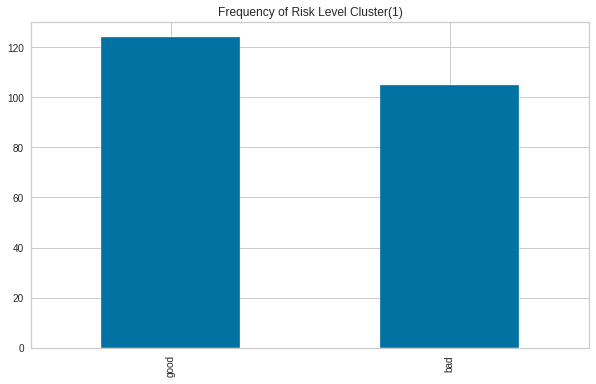

In [ ]:
# Bar plots to show the difference of the number of observations per risk level
df_scaled[df_scaled.Clusters == 0]['Risk'].value_counts().plot(kind='bar',
                                                               figsize=(10, 6),
                                                               title="Frequency of Risk Level Cluster(1)");

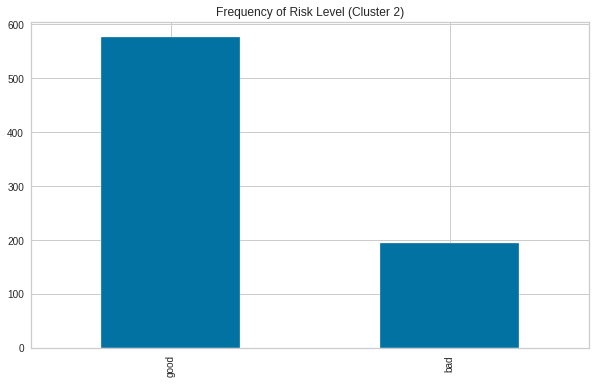

In [ ]:
df_scaled[df_scaled.Clusters == 1]['Risk'].value_counts().plot(kind='bar',
                                                               figsize=(10, 6),
                                                               title="Frequency of Risk Level (Cluster 2)");

The bar graph of cluster 1 demonstrates that there is an imbalanace distribution across risk level in the first cluster. On the other hand, the bar graph of cluster 2 demonstrates a more balanced frequency of good and bad risk levels. The class imbalance in cluster 1 is problem. We'll incorporate a oversampling and edited nearest neighbor to clean the unwanted overlapping observations between classes.

In [ ]:
# Apply a train-test split
from sklearn.model_selection import train_test_split

df_scaled['Risk'] = df_scaled['Risk'].replace({'good': 1, 'bad': 0})

X = df_scaled.drop('Risk', axis=1)
y = df_scaled.loc[:, ['Risk', 'Clusters']]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

first_cluster_train = X_train[X_train.Clusters == 0].iloc[:, :-1]
second_cluster_train = X_train[X_train.Clusters == 1].iloc[:, :-1]

In [ ]:
# Run the logistic regression to predict the probability of default
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.combine import SMOTEENN
import warnings 
warnings.filterwarnings('ignore')

X_train1 = first_cluster_train
y_train1 = y_train[y_train.Clusters == 0]['Risk']
smote = SMOTEENN(random_state=2)
X_train1, y_train1 = smote.fit_resample(X_train1, y_train1.ravel())
logit = sm.Logit(y_train1, X_train1)
logit_fit1 = logit.fit()
print(logit_fit1.summary())


Optimization terminated successfully.
         Current function value: 0.575443
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   49
Model:                          Logit   Df Residuals:                       45
Method:                           MLE   Df Model:                            3
Date:                Mon, 20 Feb 2023   Pseudo R-squ.:                  0.1490
Time:                        18:40:25   Log-Likelihood:                -28.197
converged:                       True   LL-Null:                       -33.133
Covariance Type:            nonrobust   LLR p-value:                   0.01968
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age              -0.1496      0.331     -0.452      0.651      -0.798       0.499
Job               1.

For the set of training examples from cluster 1, the `age`, `credit`, `amount`, and `job` variables are positively related with the creditworthiness of customers, while a negative association emerges between the dependent and duration variables. This finding suggests that all the estimated coefficients reveal statistically significant results at a 1% significance level. A general interpretation would be that a slide in duration and a surge in credit amount, age, and job imply a high probility of default.

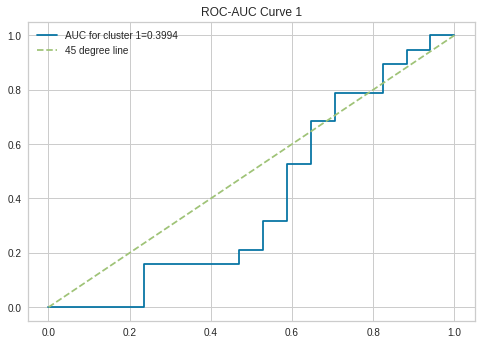

In [ ]:
# Inference on test data
first_cluster_test = X_test[X_test.Clusters == 0].iloc[:, :-1]
second_cluster_test = X_test[X_test.Clusters == 1].iloc[:, :-1]

X_test1 = first_cluster_test
y_test1 = y_test[y_test.Clusters == 0]['Risk']
pred_prob1 = logit_fit1.predict(X_test1)

false_pos, true_pos, _ = roc_curve(y_test1.values, pred_prob1)
auc = roc_auc_score(y_test1, pred_prob1)
plt.plot(false_pos, true_pos, label=f"AUC for cluster 1={auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle = '--', label='45 degree line')
plt.legend(loc='best')
plt.title('ROC-AUC Curve 1')
plt.show()

The ROC-AUC curve suggests that the performance of the model is poor, because it moves just above the 45-degree line (45-degree line would be the result of random predictions).

In [ ]:
X_train2 = second_cluster_train
y_train2 = y_train[y_train.Clusters == 1]['Risk']
logit = sm.Logit(y_train2, X_train2)
logit_fit2 = logit.fit()
print(logit_fit2.summary())

Optimization terminated successfully.
         Current function value: 0.603080
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  607
Model:                          Logit   Df Residuals:                      603
Method:                           MLE   Df Model:                            3
Date:                Mon, 20 Feb 2023   Pseudo R-squ.:                -0.06818
Time:                        18:40:26   Log-Likelihood:                -366.07
converged:                       True   LL-Null:                       -342.70
Covariance Type:            nonrobust   LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age               0.3933      0.098      4.023      0.000       0.202       0.585
Job              -0.

For the set of training samples obtained from the second clsuter, the signs of the estimated coefficients of `job`, `duration`, and `age` are positive, while the signs of `age` and `credit amount` are negative. The signs of the coeficcients suggest that customers with job type of 1 and having larger duration tend to default. However, all the estimated coefficients are statistically insginificant at 95% condfidence interval. Therefore, it would be counterintuitive to further interpret the findings.

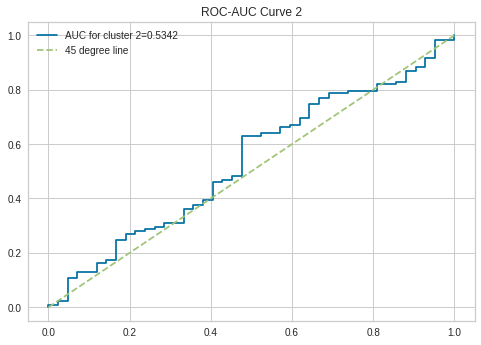

In [ ]:
# Create prediction probabilites for second cluster test set
X_test2 = second_cluster_test
y_test2 = y_test[y_test.Clusters == 1]['Risk']
pred_prob2 = logit_fit2.predict(X_test2)

false_pos, true_pos, _ = roc_curve(y_test2.values, pred_prob2)
auc = roc_auc_score(y_test2, pred_prob2)
plt.plot(false_pos, true_pos, label=f"AUC for cluster 2={auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle = '--', label='45 degree line')
plt.legend(loc='best')
plt.title('ROC-AUC Curve 2')
plt.show()

Given the test data, the result illustrated in the ROC curve is worse than the previous application. Considering this data, we can not say that logistic regression is doing a job of modelling the probability of default for this dataset.

### Bayesian Model

In [ ]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=1de8defed2d6e34c1fff088cc0ad490b42ba59456687d6d7cad7470bec3f5b19
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


In [ ]:
import pymc3 as pm
import arviz as az

with pm.Model() as logistic_model1:
  beta_age = pm.Normal('coeff_age', mu=0, sd=10)
  beta_job = pm.Normal('coeff_job', mu=0, sd=10)
  beta_credit = pm.Normal('coeff_credit_amount', mu=0, sd=10)
  beta_dur = pm.Normal('coeff_duration', mu=0, sd=10)
  p = pm.Deterministic('p', pm.math.sigmoid(beta_age *
                            X_train1['Age'] + beta_job *
                            X_train1['Job'] + beta_credit *
                            X_train1['Credit amount'] + beta_dur *
                            X_train1['Duration']))
  
with logistic_model1:
  observed = pm.Bernoulli("risk", p, observed=y_train1)
  map_estimate = pm.find_MAP()

In [ ]:
param_list = ['coeff_age', 'coeff_job',
              'coeff_credit_amount', 'coeff_duration']
params = {}
for i in param_list:
  params[i] = [np.round(map_estimate[i], 6)] 

bayesian_params = pd.DataFrame.from_dict(params)
print(f'The result of Bayesian estimation: \n{bayesian_params}')      

The result of Bayesian estimation: 
   coeff_age  coeff_job  coeff_credit_amount  coeff_duration
0  -0.148026   1.080937            -0.980716        0.918227


The most noticebale observation is that the differences between estimated coefficients are so small that they can be ignored. Taking the estimated coefficient of the credit amount variables as an example, we have estimated the coefficient to be 1.3338 in logistic regression and 1.3316 in Bayesian analysis.

In [ ]:
with pm.Model() as logistic_model2:
  beta_age = pm.Normal('coeff_age', mu=0, sd=10)
  beta_job = pm.Normal('coeff_job', mu=0, sd=10)
  beta_credit = pm.Normal('coeff_credit_amount', mu=0, sd=10)
  beta_dur = pm.Normal('coeff_duration', mu=0, sd=10)
  p = pm.Deterministic('p', pm.math.sigmoid(beta_age *
                            second_cluster_train['Age'] +
                            beta_job * second_cluster_train['Job'] + 
                            beta_credit *
                            second_cluster_train['Credit amount'] +
                            beta_dur *
                            second_cluster_train['Duration']))
  
with logistic_model2:
  observed = pm.Bernoulli("risk", p,
                          observed=y_train[y_train.Clusters == 1]['Risk'])
  map_estimate = pm.find_MAP()

In [ ]:
param_list = ['coeff_age', 'coeff_job', 'coeff_credit_amount', 'coeff_duration']

params = {}
for i in param_list:
  params[i] = [np.round(map_estimate[i], 6)]

bayesian_params = pd.DataFrame.from_dict(params)
print(f"The results of Bayesian estimation:\n {bayesian_params}")

The results of Bayesian estimation:
    coeff_age  coeff_job  coeff_credit_amount  coeff_duration
0    0.39324  -0.060987               -0.674       -0.801389


The narrative is practically the same when it comes to comparing the analysis results on the second cluster data. For example, the estimated coefficients of the `duration` variable are  0.0786 and 0.078601 in logistic regression and Bayesian estimation, respectively.

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


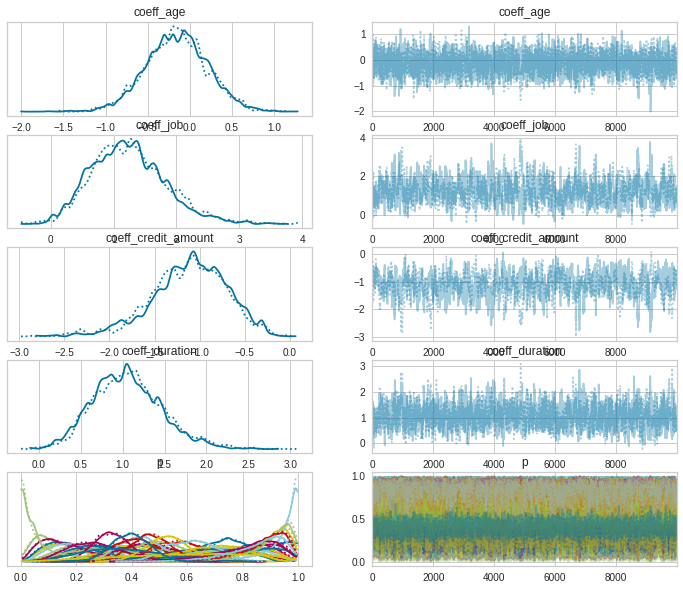

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coeff_age,-0.156393,0.366310,-0.833101,0.538456,0.009750,0.006896,1426.783680,2581.785198,1.000649
coeff_job,1.245949,0.596728,0.138965,2.308515,0.030493,0.022002,399.160429,649.829140,1.002343
coeff_credit_amount,-1.119160,0.419767,-1.851436,-0.288752,0.023142,0.016579,342.593925,497.626372,1.004658
coeff_duration,1.059894,0.413694,0.277029,1.833755,0.015454,0.011096,741.105307,1218.442091,1.004242


In [ ]:
# Bayesian estimation based on the M-H algorithm
import logging 
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

with logistic_model1:
  step = pm.Metropolis()
  trace = pm.sample(10000, step=step, progressbar=False)
az.plot_trace(trace)
plt.show()
with logistic_model1:
  display(az.summary(trace, round_to=6)[:4])  

The results suggets that the predicitve peformance performances of the bayesian esimator and the logistic regression models are very similar for the first cluster.

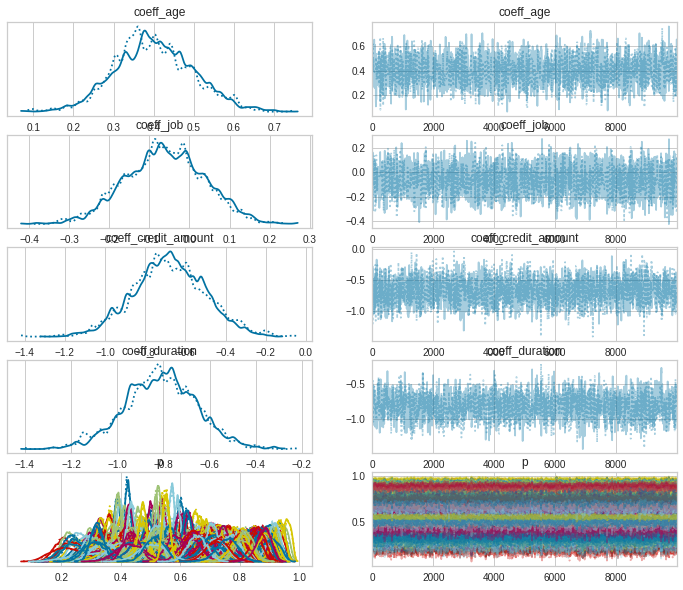

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coeff_age,0.400799,0.096656,0.245403,0.606712,0.002209,0.001589,1920.324047,1929.122223,1.001503
coeff_job,-0.062330,0.098507,-0.247383,0.116169,0.002061,0.001529,2293.277567,2323.210714,1.001174
coeff_credit_amount,-0.680823,0.179546,-1.023454,-0.350056,0.004332,0.003064,1716.695375,1871.384565,1.002745
coeff_duration,-0.812618,0.157269,-1.130543,-0.532253,0.004226,0.002989,1402.662849,1920.256257,1.000204


In [ ]:
with logistic_model2:
  step = pm.Metropolis()
  trace = pm.sample(10000, step=step, progressbar=False)
  az.plot_trace(trace)
  plt.show()
with logistic_model2:
  display(az.summary(trace, round_to=6)[:4])

### Support Vector Machines

In [ ]:
from sklearn.svm import SVC 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import time

param_svc = {'gamma': [1e-6, 1e-2],
             'C': [0.001, .09, 1, 4, 10],
             'kernel': ('linear', 'rbf')}

svc = SVC(class_weight='balanced')
halve_SVC = HalvingRandomSearchCV(svc, param_svc, 
                                  scoring='roc_auc', n_jobs=-1)
halve_SVC.fit(X_train1, y_train1)
print(f"Best hyperparameters for first cluster in SVC {halve_SVC.best_score_} with {halve_SVC.best_params_}")

Best hyperparameters for first cluster in SVC 0.5 with {'kernel': 'linear', 'gamma': 0.01, 'C': 4}


The AUC performance criteria indicates that the predictive performance of SVC is slightly below that of logistic regression for the first cluster.

In [ ]:
halve_SVC.fit(X_train2, y_train2)
print(f"Best hyperparameters for second cluster in SVC {halve_SVC.best_score_} with { halve_SVC.best_params_}")

Best hyperparameters for second cluster in SVC 0.6775967954231501 with {'kernel': 'rbf', 'gamma': 1e-06, 'C': 0.001}


In [ ]:
y_pred_SVC2 = halve_SVC.predict(X_test2)
print(f"The ROC AUC score of SVC for first cluster is {roc_auc_score(y_test2, y_pred_SVC2)}")

The ROC AUC score of SVC for first cluster is 0.5


The second clusters shows that the performance of SVC is even worse than that of the first cluster, demonstrating that SVC does not perform well on this data, as it it not clearly separable.

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)

param_rfc = {'n_estimators': [100, 300], 
             'criterion': ['gini', 'entropy'],
             'max_features': ['auto', 'sqrt', 'log2'],
             'max_depth': [3, 4, 5, 6],
             'min_samples_split': [5, 10]}

halve_RF = HalvingRandomSearchCV(rfc, param_rfc, scoring='roc_auc', n_jobs=-1)
halve_RF.fit(X_train1, y_train1)
print(f"Best hyperparameters for first cluster in RF {halve_RF.best_score_} with {halve_RF.best_params_}")

Best hyperparameters for first cluster in RF 0.7 with {'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 3, 'criterion': 'gini'}


In [ ]:
y_pred_RF1 = halve_RF.predict(X_test1)
score1 = roc_auc_score(y_test1, y_pred_RF1)
print(f"The ROC AUC score of RF for first cluster is {score1:.4f}")

The ROC AUC score of RF for first cluster is 0.5093


Given the first cluster data, the AUC score of 0.5387 indicates that random forest has a better performance compared to the other models.

In [ ]:
halve_RF.fit(X_train2, y_train2)
print(f"Best hyperparameters for second cluster in RF {halve_RF.best_score_} with {halve_RF.best_params_}")

Best hyperparameters for second cluster in RF 0.635809360016677 with {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'entropy'}


In [ ]:
y_pred_RF2 = halve_RF.predict(X_test2)
score2 = roc_auc_score(y_test2, y_pred_RF2) 
print(f"The ROC AUC score of RF for second cluster is {score2:.4f}")

The ROC AUC score of RF for second cluster is 0.5119


Random forest has a much better predicitve performance in the second cluster, with an AUC score of 0.6563. Given the predictive performance of a random forest, we can conclude that random forest does a better job of fitting the data. This is partly because of the low-dimensional characteristics of the data.

### Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

param_NN = {"hidden_layer_sizes": [(100, 50), (50, 50), (10, 100)],
            "solver": ["lbfgs", "sgd", "adam"],
            "learning_rate_init": [0.001, 0.05]}
MLP = MLPClassifier(random_state=42)
param_halve_NN = HalvingRandomSearchCV(MLP, param_NN,
                                       scoring='roc_auc')
param_halve_NN.fit(X_train1, y_train1)
print(f"Best hyperparameters for first cluster in NN are {param_halve_NN.best_params_}")

Best hyperparameters for first cluster in NN are {'solver': 'lbfgs', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (10, 100)}


In [ ]:
param_halve_NN.fit(X_train2, y_train2)
print(f"Best hyperparameters for first cluster in NN are {param_halve_NN.best_params_}")

Best hyperparameters for first cluster in NN are {'solver': 'sgd', 'learning_rate_init': 0.05, 'hidden_layer_sizes': (100, 50)}


Comparing the optimized hyperparameters of the two clusters indicates that every parameter is different. The second cluster has a larger number of neurons, a higher learning_rate, and uses `sgd`.

In [ ]:
y_pred_NN1 = param_halve_NN.predict(X_test1)
score1 = roc_auc_score(y_test1, y_pred_NN1)
print(f"The ROC AUC score of NN for second cluster is {score1:.4f}")

The ROC AUC score of NN for second cluster is 0.5031


In [ ]:
y_pred_NN2 = param_halve_NN.predict(X_test2)
score2 = roc_auc_score(y_test2, y_pred_NN2)
print(f"The ROC AUC score of NN for the second cluster is {score2}")

The ROC AUC score of NN for the second cluster is 0.5275175644028103


### Comparing Models

### Conclusion